<a href="https://colab.research.google.com/github/Hee0305/DL/blob/main/final22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


from tensorflow.keras.utils import to_categorical


# import cv2
print(tf.__version__)

2.7.0


In [107]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


**Load Data**

In [108]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

**Data augmentation**

In [109]:
from keras.preprocessing.image import ImageDataGenerator

In [131]:
datagen = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.9,
                             rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1
                             )

train_generator = datagen.flow(x_train,
                               y_train,
                               batch_size=32,
                               shuffle=True,
                               seed=42,
                               subset='training')

valid_generator = datagen.flow(x_test,
                               y_test,
                               batch_size=32,
                               seed=42
                               )

In [136]:
print(len(train_generator))
print(len(valid_generator))

157
313


In [137]:
print(train_generator.n)
print(valid_generator.n)

5000
10000


**Model ( MobileNetV2 )**

In [113]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [114]:
len(TL_base.layers)

154

In [115]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [116]:
TL_base.layers[-1].get_config() # (7, 7, 1280)

{'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'name': 'out_relu',
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32),
 'trainable': True}

**Sequential model**

In [117]:
TL_base.trainable = False  # Use the representative features pretrained by resnet.

In [118]:
ko = tf.keras.optimizers.SGD(learning_rate=0.001)
# lr = 0.0005

model = models.Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer = ko , loss='categorical_crossentropy', metrics = ['accuracy'])

In [119]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

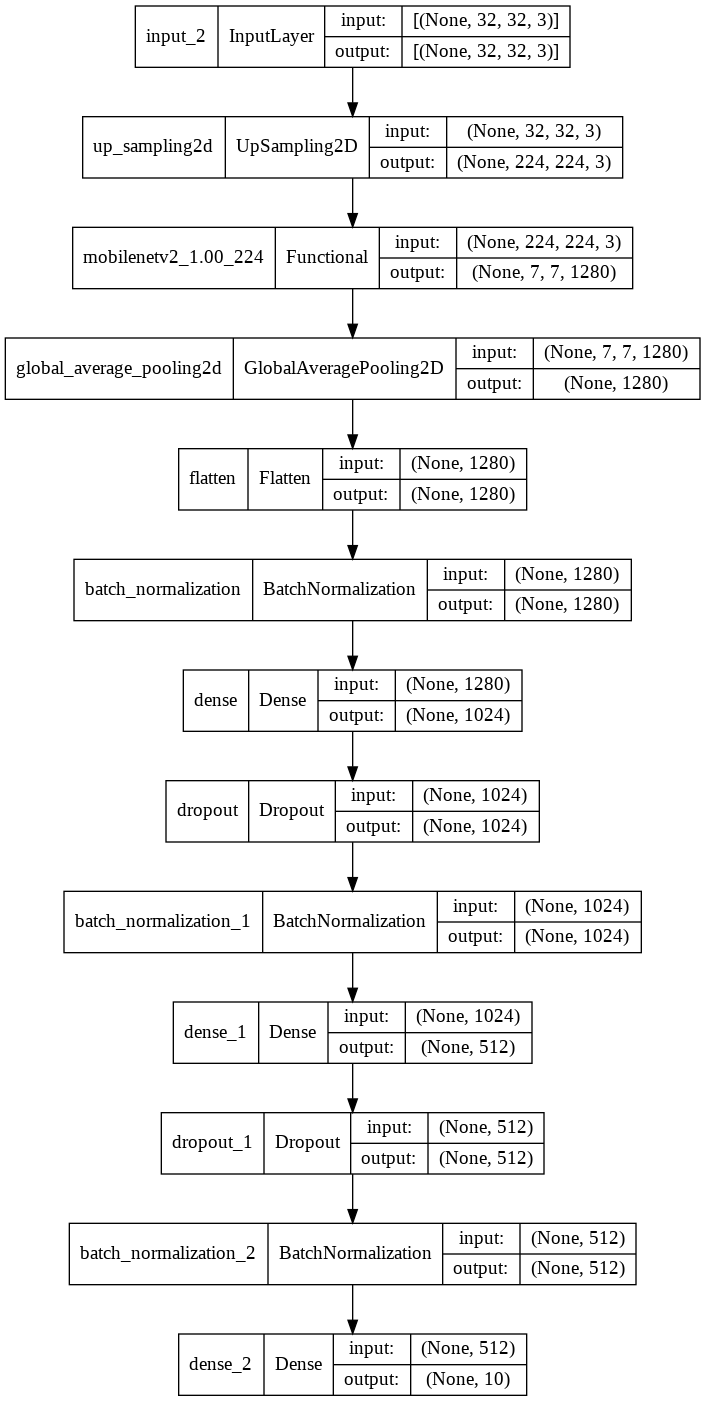

In [120]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_S.png')

In [121]:
from tensorflow.keras import layers, models, callbacks

In [122]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobilenetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [123]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100)

Epoch 1/100
156/156 [==============================] - 43s 247ms/step - loss: 2.9119 - accuracy: 0.1298 - val_loss: 2.1499 - val_accuracy: 0.1933


KeyboardInterrupt: ignored

**Fine tuning**

In [ ]:
# Unfreeze all layers in base model
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(TL_base.layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Compile model
model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobileNetV2S_FT_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

**Train fine-tuned model**

In [ ]:
history_dict = history.history
loss = history_dict['loss']

INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [ ]:
%%time
history_fine = model.fit(train_generator, 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    batch_size=32, 
                    validation_data=valid_generator,
                    callbacks=[mc_callback,es_callback])